In [2]:
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
%matplotlib inline
from IPython.display import display
from qiskit import pulse as pul                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

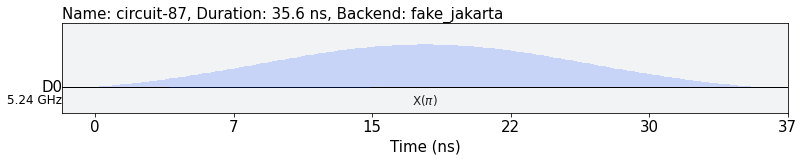

In [4]:
from qiskit.test.mock import FakeArmonk
from qiskit import transpile, schedule as build_schedule
from qiskit.test.mock import FakeJakarta

backend = FakeJakarta()

qc = qk.QuantumCircuit(1,0)
qc.x(0)
#qc.barrier()
#qc.measure([0],[0])
tran_qc= transpile(qc, backend)
pulse_sched= build_schedule(tran_qc,backend)

tran_qc.draw('mpl')

pulse_sched.draw(backend=backend)

In [7]:
pulse_sched

Schedule((0, Play(Drag(duration=160, amp=(0.2012211411684789+0j), sigma=40, beta=-1.0205387662332952, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="circuit-2")

In [54]:
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
backend = provider.get_backend("ibmq_guadalupe")
from qiskit import pulse
temp = (pulse.library.Drag(duration=160, amp=(0.2012211411684789+0j), sigma=40, beta=-1.0205387662332952, name='Xp_d0')).get_waveform()
output = temp.samples


In [58]:
import pickle
with open('x_gate_sampling', 'wb') as handle:
    pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
print(int(169/64))

2


## comparison

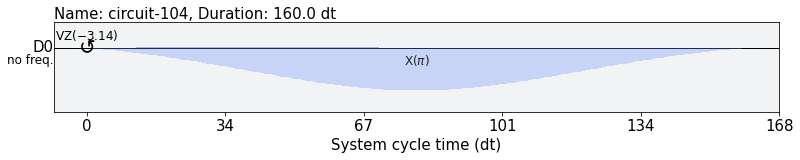

In [7]:
qc = qk.QuantumCircuit(1,0)
qc.y(0)
#qc.barrier()
#qc.measure([0],[0])
tran_qc= transpile(qc, backend)
pulse_sched= build_schedule(tran_qc,backend)

tran_qc.draw('mpl')

pulse_sched.draw()

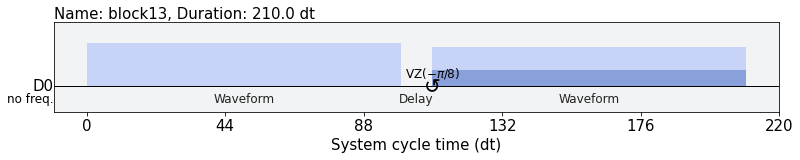

In [20]:
from qiskit import pulse
temp = [1 for i in range(100)]
with pulse.build(backend=backend) as custom_Pulse:
        [pulse.play(temp, pulse.drive_channel(0))]
        pulse.delay(10,pulse.drive_channel(0))
        pulse.shift_phase(np.pi/8,pulse.drive_channel(0))
        [pulse.play(temp, pulse.drive_channel(0))]
custom_Pulse.draw()

In [9]:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

C:\Users\Fanuel\AppData\Local\Temp\ipykernel_13004\2679117562.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter


In [101]:
armonk_backend = FakeArmonk()
armonk_model = PulseSystemModel.from_backend(armonk_backend)
backend_sim = PulseSimulator(system_model=armonk_model)
num_shots_per_frequency = 100000
pulse_sched_fin = assemble(pulse_sched,
                     backend=backend_sim,
                     meas_level=2,
                     meas_return='avg',
                     shots=num_shots_per_frequency)

In [102]:
frequency_sweep_results = backend_sim.run(pulse_sched_fin).result()

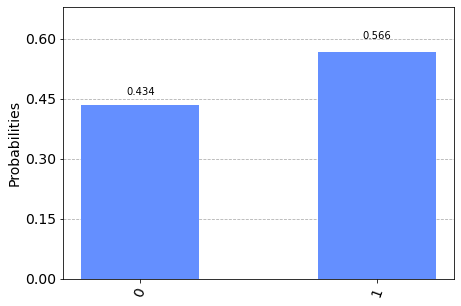

In [103]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(frequency_sweep_results.get_counts())

In [83]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0
# We will define memory slot channel 0.
mem_slot = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = 4.9*GHz     # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-15

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 1000 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 10 * MHz
# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange((frequency_min / GHz), 
                            (frequency_max / GHz), 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")
print(len(frequencies_GHz))

Qubit 0 has an estimated frequency of 4.9 GHz.
The sweep will go from 4.4 GHz to 5.4 GHz in steps of 10.0 MHz.
100


0j


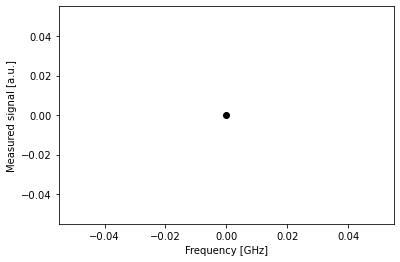

In [85]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[0])
    if (i%4==0): print((frequency_sweep_results.get_memory(i))[0])

plt.scatter(np.real(sweep_values), np.real(sweep_values), color='black') # plot real part of sweep values
#plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()